In [1]:
from __future__ import unicode_literals
from textblob import TextBlob
import pandas as pd

In [2]:
wine = pd.read_csv('/Users/luis/Desktop/master_codes/tfm/winemag-data_first150k.csv.zip',sep=",")
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
wine.columns

Index([u'Unnamed: 0', u'country', u'description', u'designation', u'points',
       u'price', u'province', u'region_1', u'region_2', u'variety', u'winery'],
      dtype='object')

In [4]:
wine = wine.drop('Unnamed: 0',1)
wine = wine.drop_duplicates()
len(wine)


97851

In [5]:
# keeping only varieties with at least 20 reviews
num_reviews = wine.groupby('variety').description.count().to_frame().reset_index()
num_reviews = num_reviews[num_reviews.description > 19]
frequent_varieties = num_reviews.variety.tolist()
wine = wine.loc[wine['variety'].isin(frequent_varieties)]

In [6]:
len(wine)

95778

In [7]:
# first we must clean the text by removing punctuation symbols and setting all words 
# to lowercase letters
import string 

def remove_punctuation(review):
    pepe = review.translate(None, string.punctuation)
    return pepe

# removing punctuation from descriptions
wine['description'] = wine['description'].apply(remove_punctuation)
# converting to lowercase letters
wine['description'] = wine['description'].str.lower()

Classifying varieties by grape color

In [8]:
# we will keep only varieties containing at least 10 descriptions
num_reviews = wine.groupby('variety').description.count().to_frame().reset_index()
num_reviews = num_reviews[num_reviews.description > 9]
frequent_varieties = num_reviews.variety.tolist()
wine_ff = wine.loc[wine['variety'].isin(frequent_varieties)]

In [9]:
#writing it as a function that assigns a redness-score based on a list of descriptions
def redness_score(descriptions):
    red_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        n1 = review.words.count("cherry")
        n2 = review.words.count("berry")
        n3 = review.words.count("cherries")
        n4 = review.words.count("berries")
        n5 = review.words.count("red")
        n6 = review.words.count("raspberry")
        n7 = review.words.count("raspberries")
        n8 = review.words.count("blueberry")
        n9 = review.words.count("blueberries")
        n10 = review.words.count("blackberry")
        n11 = review.words.count("blackberries")
        total_red = n1+n2+n3+n4+n5+n6+n7+n8+n9+n10+n11
        red_freq.append(total_red)
    return float(sum(red_freq))/len(red_freq)

In [10]:
#writing it as a function that assigns a redness-score based on a list of descriptions
def whiteness_score(descriptions):
    white_freq = []
    for review in descriptions:
        review = TextBlob(review.decode('unicode-escape'))
        n1 = review.words.count("lemon")
        n2 = review.words.count("lemons")
        n3 = review.words.count("lime")
        n4 = review.words.count("limes")
        n5 = review.words.count("peach")
        n6 = review.words.count("peaches")
        n7 = review.words.count("white")
        n8 = review.words.count("apricot")
        n9 = review.words.count("pear")
        n10 = review.words.count("apple")
        n11 = review.words.count("nectarine")
        n12 = review.words.count("orange")
        n13 = review.words.count("pineapple")
        total_white = n1+n2+n3+n4+n5+n6+n7+n8+n9+n10+n11+n12+n13
        white_freq.append(total_white)
    return float(sum(white_freq))/len(white_freq)

In [11]:
red_types = []
for variety in wine_ff.variety.unique():
    df_variety = wine_ff[wine_ff.variety == variety]
    red = redness_score(df_variety.description)
    red_types.append((variety,red)) # a redness score is asigned to each variety

In [12]:
# putting it in dataframe format
color_classification =  pd.DataFrame.from_records(red_types,columns=["variety","redness_score"])

In [13]:
white_types = []
for variety in wine_ff.variety.unique():
    df_variety = wine_ff[wine_ff.variety == variety]
    white = whiteness_score(df_variety.description)
    white_types.append((variety,white)) # a whiteness score is asigned to each variety

In [14]:
white = pd.DataFrame.from_records(white_types,columns=["variety","whiteness_score"])

In [15]:
# merging the two dataframes, we have a dataframe which, for each variety provides a redness and whiteness score
color_classification = color_classification.merge(white,how='left',on='variety')

In [16]:
color_classification.sample(5)

,variety,redness_score,whiteness_score
12,Syrah,1.105651,0.070707
30,Pinot Grigio,0.013237,1.447653
113,Grenache Blanc,0.115385,1.692308
140,Lambrusco,1.937500,0.083333
76,Grenache-Syrah,1.279070,0.046512


In [17]:
# a function that compares the redness and whiteness score for each variety,
# and returns "red" if redness score is greater, "white" if whiteness score
# is greater, or "inconclusive" otherwise
def identify_color(redness,whiteness):
    if redness > whiteness:
        return "red"
    if redness < whiteness:
        return "white"
    else:
        return "inconclusive"

In [18]:
import numpy as np

In [19]:
color_classification['color'] = np.vectorize(identify_color)(color_classification['redness_score'], color_classification['whiteness_score'])

In [20]:
color_classification.sample(9)

,variety,redness_score,whiteness_score,color
26,Malbec-Merlot,0.966667,0.016667,red
132,Cannonau,1.360000,0.200000,red
13,Sangiovese,1.320483,0.095680,red
34,Gamay,1.064343,0.008043,red
105,Arinto,0.043478,1.173913,white
8,Tempranillo,1.341554,0.027744,red
77,Furmint,0.043478,2.304348,white
98,Müller-Thurgau,0.000000,1.478261,white
61,Sauvignon,0.011299,1.101695,white


In [21]:
color_classification.color.value_counts()

red      95
white    87
Name: color, dtype: int64

In [22]:
reds = color_classification[color_classification.color == "red"]

In [23]:
reds["color_p"] = reds.redness_score-reds.whiteness_score

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
#checking dubious cases of red wines
reds.sort_values(by='color_p').head()

,variety,redness_score,whiteness_score,color,color_p
99,Port,0.328147,0.089109,red,0.239038
117,Rosado,0.809524,0.523810,red,0.285714
62,Tannat-Cabernet,0.333333,0.000000,red,0.333333
44,Touriga Nacional,0.495798,0.000000,red,0.495798
101,Touriga Nacional-Cabernet Sauvignon,0.500000,0.000000,red,0.500000


In [25]:
whites = color_classification[color_classification.color == "white"]

In [26]:
whites["color_p"] = whites.whiteness_score-whites.redness_score

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
#checking the more dubious cases of white wines
whites.sort_values(by='color_p').head()

,variety,redness_score,whiteness_score,color,color_p
91,Portuguese Sparkling,0.206897,0.482759,white,0.275862
89,Champagne Blend,0.254007,0.573366,white,0.319359
71,Sherry,0.000000,0.619718,white,0.619718
126,Pedro Ximénez,0.000000,0.692308,white,0.692308
55,Chenin Blanc-Chardonnay,0.000000,0.692308,white,0.692308


In [28]:
# including color column in descriptions dataframe by merging
wine = wine.merge(color_classification,how='left',on="variety")

In [30]:
white = wine[wine.color=="white"]
red = wine[wine.color=="red"]

In [31]:
def polarity_function(review):#measures polarity of wine description
    opinion_wine=TextBlob(review.decode('unicode-escape'))
    return opinion_wine.sentiment.polarity

def subjectivity_function(review): #measures subjectivity of wine description
    opinion_wine=TextBlob(review.decode('unicode-escape'))
    return opinion_wine.sentiment.subjectivity

def words_function(review): # measures the length of the wine description by number of words
    t=TextBlob(review.decode('unicode-escape'))
    return len(t.words)

In [32]:
red['polarity']= red.description.apply(polarity_function)
red['num_words'] = red.description.apply(words_function)

white['polarity']= white.description.apply(polarity_function)
white['num_words'] = white.description.apply(words_function)

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [33]:
# we add a new column termed "quality", if points > 90 the wine is high quality, else we consider it low quality

def rating_type(score):
    if score > 92:
        return 1
    if score <= 84:
        return 0
    if score>84 and score<=92:
        return 2


red['quality'] = red.points.apply(rating_type)
red_bad = red[red.quality==0]
red_good = red[red.quality==1]
red_f = red[red.quality.isin([0,1])==True]

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
white['quality'] = white.points.apply(rating_type)
white_bad = white[white.quality==0]
white_good = white[white.quality==1]
white_f = white[white.quality.isin([0,1])==True]

/Users/luis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [35]:
white_f.quality.value_counts()

0    4971
1    2172
Name: quality, dtype: int64

In [36]:
red.points.mean()

88.13038381726307

In [37]:
import nltk

In [38]:
bad_adjective_list = []
for description in red_bad.description:
    description = TextBlob(description.decode('unicode-escape'))
    description = nltk.pos_tag(description.split())
    for i in range(len(description)):
        tupl=description[i]
        if tupl[1] == 'JJ':
            bad_adjective_list.append(tupl[0])   

In [39]:
bad_adjectives = pd.DataFrame({'adjective_list': bad_adjective_list})
df_adj_bad = bad_adjectives.adjective_list.value_counts().sort_values(ascending=False).to_frame().reset_index()

In [40]:
import matplotlib.pyplot as plt

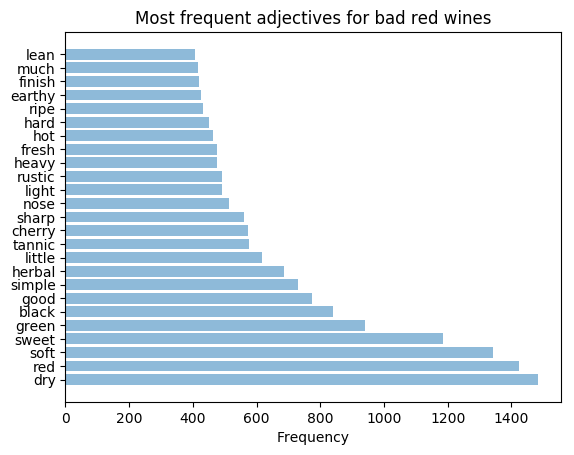

In [43]:
plt.rcdefaults()
fig, ax = plt.subplots()

adjectives = tuple(df_adj_bad['index'].tolist())[:25]
adjectives = [TextBlob(i.decode('unicode-escape')) for i in adjectives]
y_pos = np.arange(len(adjectives))
performance = np.array(df_adj_bad.adjective_list)[:25]
error = np.random.rand(len(adjectives))


plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, adjectives)
plt.xlabel('Frequency')
plt.title('Most frequent adjectives for bad red wines')
 
plt.show()

In [46]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt

def create_Word_Corpus(df):
    words_corpus = ''
    for val in df["description"][:500]:
        val = val.decode('utf-8')
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus

# Generate a word cloud image
red_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(red_good))
white_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(white_good))

In [48]:
# Plot cloud for white wines
def plot_Cloud(wordCloud):
    plt.figure( figsize=(10,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='k', bbox_inches='tight')

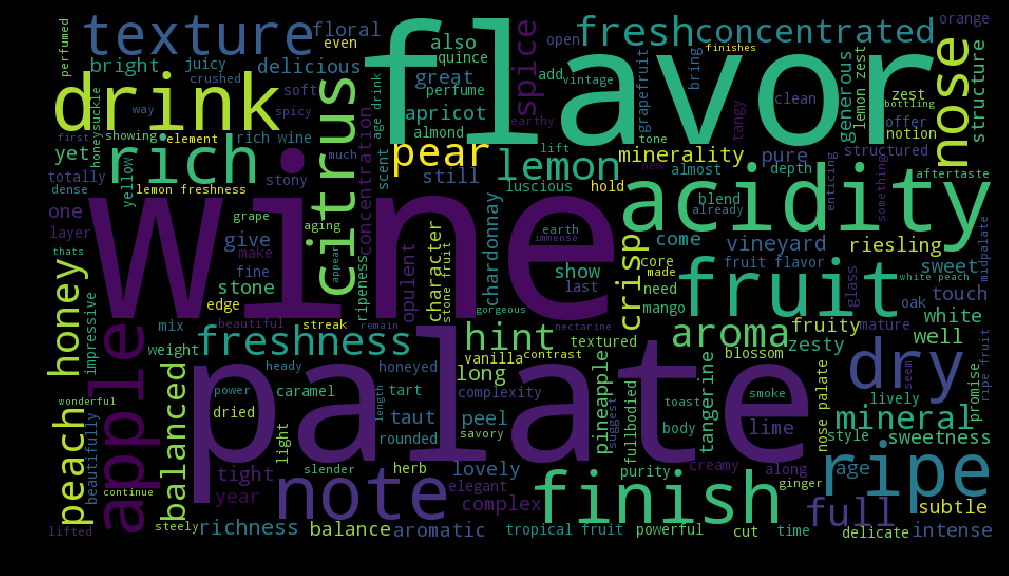

In [49]:
plot_Cloud(white_wordcloud)

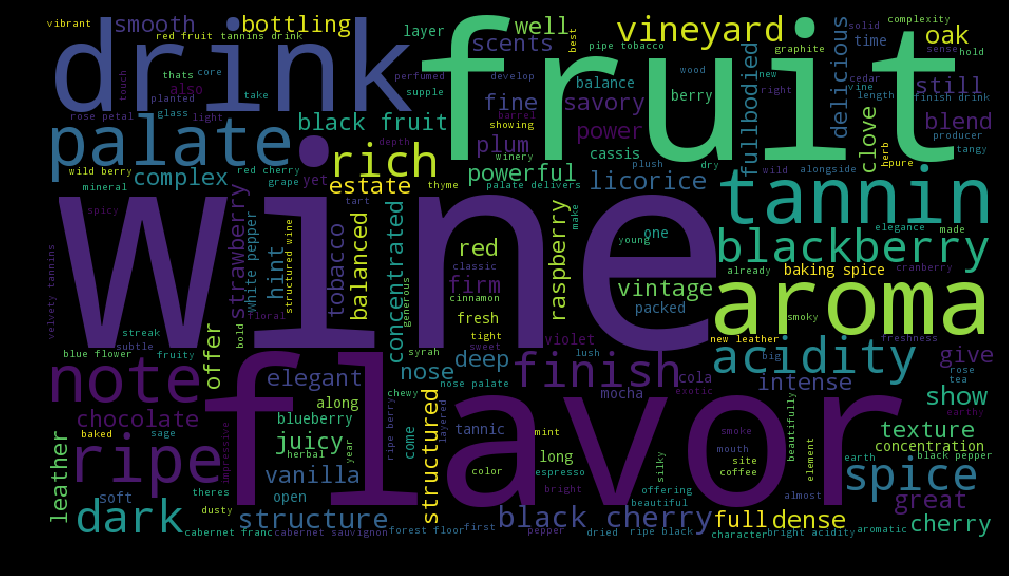

In [50]:
plot_Cloud(red_wordcloud)

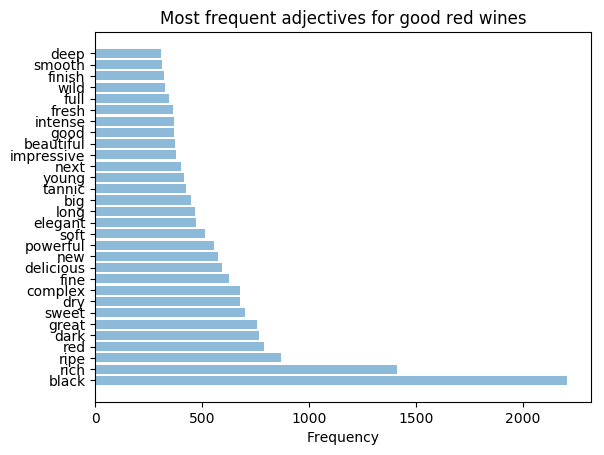

In [51]:
good_adjective_list = []
for description in red_good.description:
    description = TextBlob(description.decode('unicode-escape'))
    description = nltk.pos_tag(description.split())
    for i in range(len(description)):
        tupl=description[i]
        if tupl[1] == 'JJ':
            good_adjective_list.append(tupl[0])  
            
good_adjectives = pd.DataFrame({'adjective_list': good_adjective_list})
df_adj_good = good_adjectives.adjective_list.value_counts().sort_values(ascending=False).to_frame().reset_index()

            
plt.rcdefaults()
fig, ax = plt.subplots()

adjectives = tuple(df_adj_good['index'].tolist())[:30]
adjectives = [TextBlob(i.decode('unicode-escape')) for i in adjectives]
y_pos = np.arange(len(adjectives))
performance = np.array(df_adj_good.adjective_list)[:30]
error = np.random.rand(len(adjectives))


plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, adjectives)
plt.xlabel('Frequency')
plt.title('Most frequent adjectives for good red wines')
 
plt.show()            

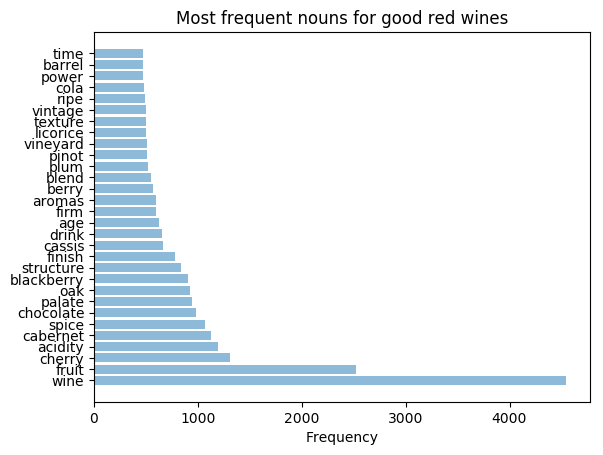

In [52]:
good_noun_list = []
for description in red_good.description:
    description = TextBlob(description.decode('unicode-escape'))
    description = nltk.pos_tag(description.split())
    for i in range(len(description)):
        tupl=description[i]
        if tupl[1] == 'NN':
            good_noun_list.append(tupl[0])  
            
good_nouns = pd.DataFrame({'noun_list': good_noun_list})
df_noun_good = good_nouns.noun_list.value_counts().sort_values(ascending=False).to_frame().reset_index()

            
plt.rcdefaults()
fig, ax = plt.subplots()

nouns = tuple(df_noun_good['index'].tolist())[:30]
nouns = [TextBlob(i.decode('unicode-escape')) for i in nouns]
y_pos = np.arange(len(nouns))
performance = np.array(df_noun_good.noun_list)[:30]
error = np.random.rand(len(nouns))


plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, nouns)
plt.xlabel('Frequency')
plt.title('Most frequent nouns for good red wines')
plt.show()            

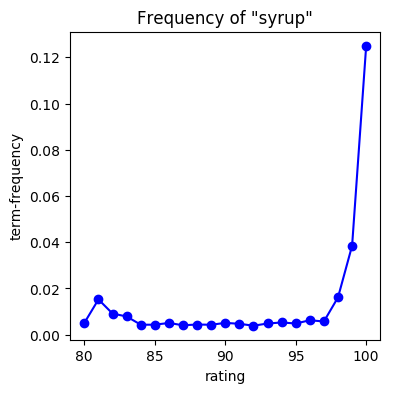

In [53]:
freq_list = []
for i in range(len(red)):
    item = red.iloc[i]
    description = item.description
    description = TextBlob(item.description.decode('unicode-escape'))
    num_adj = description.words.count("syrup")
    points = item.points
    tup = (num_adj,points)
    freq_list.append(tup)  

df = pd.DataFrame.from_records(freq_list,columns=["num_adj","points"])
df_del = df.groupby("points").num_adj.mean().to_frame().reset_index()

plt.figure(figsize=(4,4))
plt.plot(df_del.points,df_del.num_adj,"b-o")
plt.xlabel('rating')
plt.ylabel('term-frequency')
plt.title('Frequency of "syrup"')
plt.show()

In [54]:
freq_list = []
for i in range(len(red_f)):
    item = red_f.iloc[i]
    description = item.description
    description = TextBlob(item.description.decode('unicode-escape'))
    complex_ = description.words.count("complex")
    ripe = description.words.count("ripe")
    oak = description.words.count("oak")
    most = description.words.count("most")
    best = description.words.count("best")
    balanced = description.words.count("balanced")
    perfect = description.words.count("perfect")
    wine = description.words.count("wine")
    elegant = description.words.count("elegant")
    complexity = description.words.count("complexity")
    cassis = description.words.count("cassis")
    drink = description.words.count("drink")
    exotic = description.words.count("exotic")
    delicious = description.words.count("delicious")
    chocolate = description.words.count("chocolate")
    gorgeous = description.words.count("gorgeous")
    structure = description.words.count("structure")
    powerful = description.words.count("powerful")
    rustic = description.words.count("rustic")
    simple = description.words.count("simple")
    rich = description.words.count("rich")
    black = description.words.count("black")
    dark = description.words.count("dark")
    impressive = description.words.count("impressive")
    dense = description.words.count("dense")
    great = description.words.count("great")
    length = len(description.words)
    polarity = description.sentiment.polarity
    quality = item.quality
    tup = (length,polarity,complex_,ripe,oak,most,best,balanced,perfect,wine,elegant,complexity,cassis,drink,exotic,delicious,chocolate,gorgeous,structure,powerful,rustic,simple,rich,black,dark,impressive,dense,great,quality)
    freq_list.append(tup)
    
df = pd.DataFrame.from_records(freq_list,columns=["length","polarity","complex","ripe","oak","most","best","balanced","perfect","wine","elegant","complexity","cassis","drink","exotic","delicious","chocolate","gorgeous","structure","powerful","rustic","simple","rich","black","dark","impressive","dense","great","quality"])

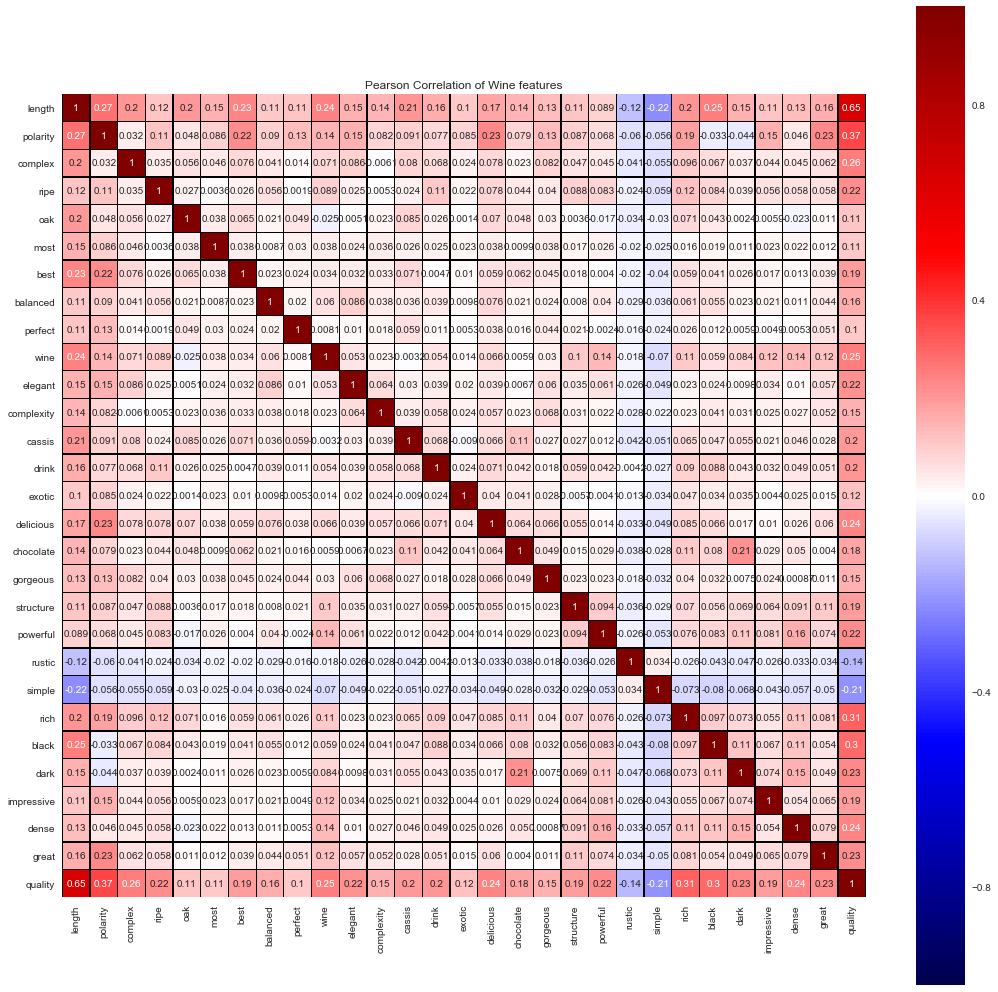

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# correlation matrix in a nice visualization
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))
plt.title('Pearson Correlation of Wine features')
# Draw the heatmap using seaborn
sns.heatmap(df.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="seismic", linecolor='black', annot=True)
plt.show()

In [57]:
X= df[["complex","ripe","oak","most","best","balanced","perfect","wine","elegant","complexity","cassis","drink","exotic","delicious","chocolate","gorgeous","structure","powerful","rustic","simple","rich","black","dark","impressive","dense","great"]]
y = df.quality.values

In [58]:
X = X.values

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.5,random_state = 42)

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [62]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()

In [63]:
clf_lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
accuracy_score(clf_lr.predict(X_test),y_test)*100

86.196078431372541

In [65]:
precision_score(clf_lr.predict(X_test),y_test)*100

75.812395309882746

In [66]:
confusion_matrix(y_test,clf_lr.predict(X_test))

array([[4331,  334],
       [ 722, 2263]])

0.926261317305


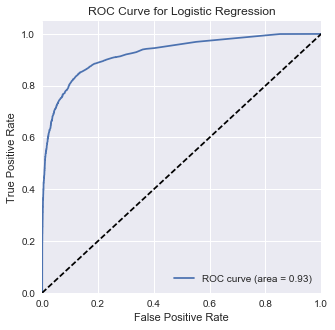

In [67]:
from sklearn.metrics import roc_curve, auc 

clf_lr.fit(X_train, y_train)
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_lr.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [68]:
# Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
clf_rf = RandomForestClassifier(oob_score=True,random_state=42)

In [71]:
clf_rf.fit(X_train,y_train)

/Users/luis/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/luis/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

0.90850407809


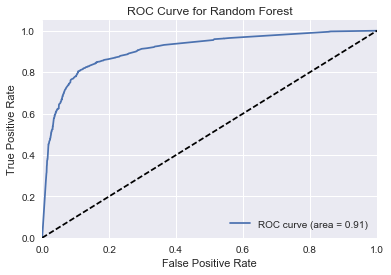

In [72]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=42)
clf_rf.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf_rf.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [73]:
# PCA+KNN, must reduce dimensionality first for KNN classifier 

In [74]:
X = df[["complex","ripe","oak","most","best","balanced","perfect","wine","elegant","complexity","cassis","drink","exotic","delicious","chocolate","gorgeous","structure","powerful","rustic","simple","rich","black","dark","impressive","dense","great"]]